In [1]:
from fish_helpers import *

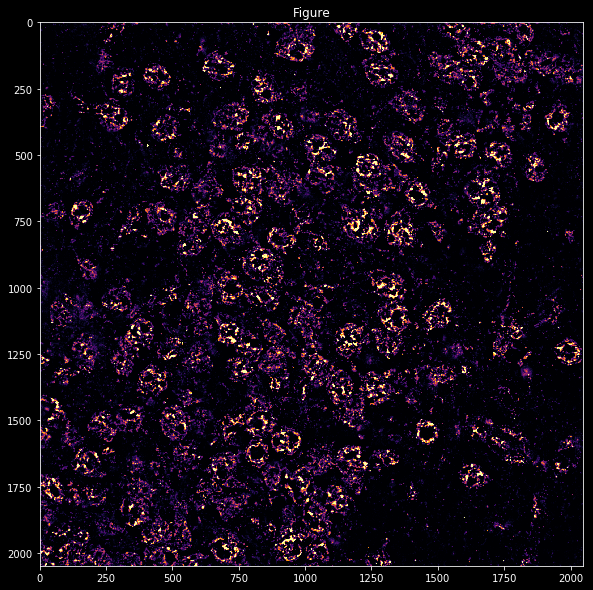

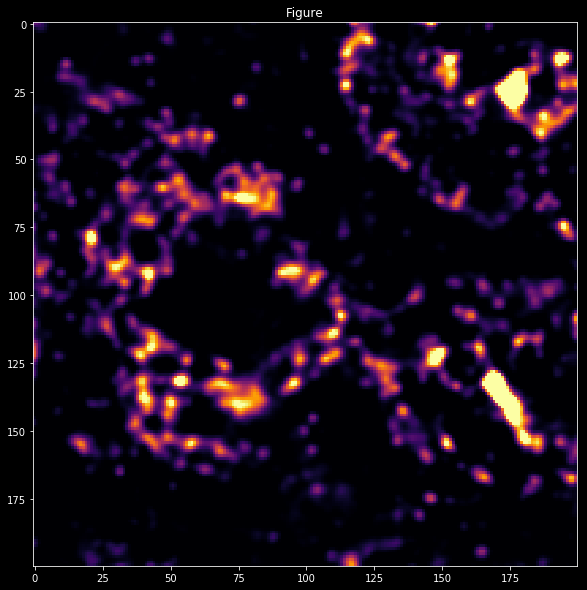

In [2]:
base_path = '/hybedata/Images/Robert/TBI_v2/sham_m3_slide4_2019Nov04/codestacks_v1/Pos1/'
hdata = HybeData(base_path)
pos = 'Pos1'
z = 15
cstk = hdata.load_data(pos,z,'cstk')
Display(np.sum(cstk,axis=2),rel_min=50)
Display(np.sum(cstk,axis=2)[900:1100,650:850],rel_min=50)

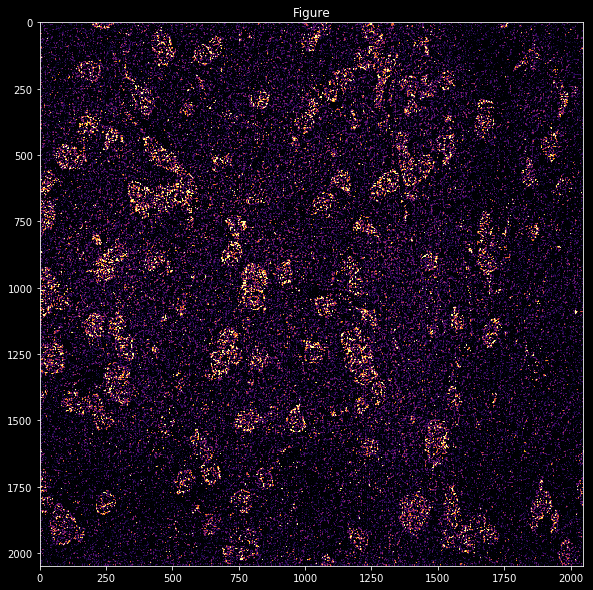

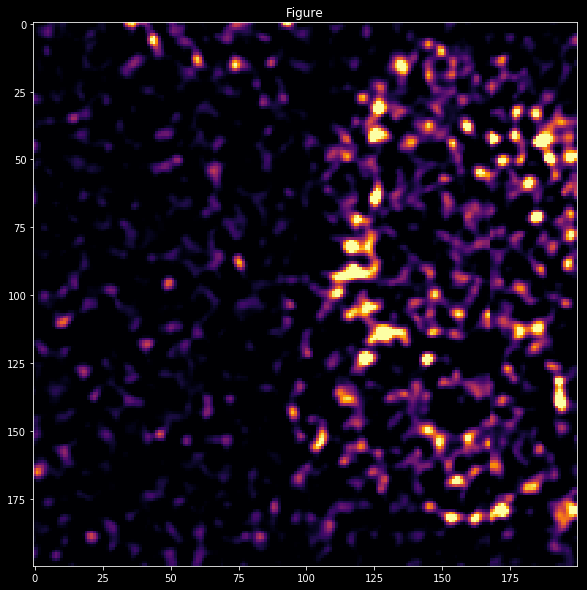

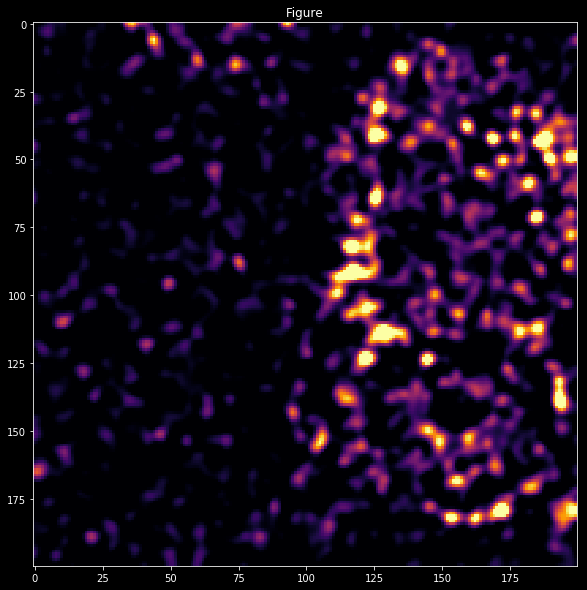

In [2]:
fishdata_path = '/hybedata/Images/Zach/ZebraFinch/A4_2020Jun28/fishdata/'
from skimage.filters import gaussian
from MERFISH_Objects.FISHData import *
fishdata = FISHData(fishdata_path)
import os
from analysis_scripts.classify import *
cword_config = 'seqfish_config_zebrafinch'
seqfish_config = importlib.import_module(cword_config)
try:
    genes = seqfish_config.gids+seqfish_config.bids
except:
    genes = seqfish_config.gids
bitmap = seqfish_config.bitmap
normalized_gene_vectors = seqfish_config.norm_gene_codeword_vectors
normalized_all_gene_vectors = seqfish_config.norm_all_codeword_vectors
all_gene_vectors = seqfish_config.all_codeword_vectors
nbits = seqfish_config.nbits
pos = 'Pos1'
z = 17
def load_codestack(fishdata,bitmap,dataset,posname,zindex):
    cstk = np.zeros((2048,2048,len(bitmap)))
    for bitmap_idx in range(len(bitmap)):
        seq,hybe,channel = bitmap[bitmap_idx]
        temp = fishdata.load_data('image',dataset=dataset,posname=posname,hybe=hybe,channel=channel,zindex=zindex)
        if not isinstance(temp,type(None)):
            cstk[:,:,bitmap_idx] = temp
    return cstk
cstk = load_codestack(fishdata,bitmap,'A4_2020Jun28',pos,z)
Display(np.sum(cstk,axis=2),rel_min=50)
Display(np.sum(cstk,axis=2)[900:1100,650:850],rel_min=50)
Display(gaussian(np.sum(cstk,axis=2)[900:1100,650:850],1),rel_min=50)

In [38]:
posnames = list(np.unique([i.split('_')[2] for i in os.listdir(fishdata_path) if 'Pos' in i]))
zindexes = list(np.unique([i.split('_')[-2] for i in os.listdir(fishdata_path) if 'Pos' in i]))
zindexes = [i for i in zindexes if not ('all' in i)|('X' in i)]
import random

In [3]:
import random
from tqdm import tqdm
# Update Codeword Vectors for additional errors 
# All 18 chose 1 options
# All 18 chose 7 options
iterations = 100
low_decoys = []
low_base = list((1*"1").zfill(18))
for i in tqdm(range(iterations),total=iterations):
    random.shuffle(low_base)
    low_decoys.append(''.join(low_base))
low_decoys = list(np.unique(low_decoys))

iterations = 1000000
high_decoys = []
high_base = list((7*"1").zfill(18))
for i in tqdm(range(iterations),total=iterations):
    random.shuffle(high_base)
    high_decoys.append(''.join(high_base))
high_decoys = list(np.unique(high_decoys))

low_decoys_array = np.array([[int(i) for i in low_decoys[j]] for j in range(len(low_decoys))])
high_decoys_array = np.array([[int(i) for i in high_decoys[j]] for j in range(len(high_decoys))])

100%|██████████| 1000000/1000000 [00:28<00:00, 35509.37it/s]


In [4]:
codeword_vectors = (normalized_all_gene_vectors/np.max(normalized_all_gene_vectors)).astype(int)
codeword_vectors = np.concatenate((codeword_vectors,low_decoys_array,high_decoys_array))
genes = list(seqfish_config.gids+seqfish_config.bids)
genes.extend(['low_decoy'+str(i) for i in range(low_decoys_array.shape[0])])
genes.extend(['high_decoy'+str(i) for i in range(high_decoys_array.shape[0])])

In [5]:
from scipy.spatial.distance import cdist
def classify_pixels(cstk,normalization_factors,codeword_vectors,rel_peak_thresh=99):
    codeword_vectors = 0.5*(codeword_vectors>0)
    if len(cstk.shape)==3:
        mask_stk = cstk.copy()
        for i in range(cstk.shape[2]):
            mask_stk[:,:,i] = 1*(cstk[:,:,i]>np.percentile(cstk[:,:,i].ravel(),rel_peak_thresh))
        mask = (np.sum(mask_stk,axis=2)>2)&(np.sum(mask_stk,axis=2)<8)
        x,y = np.where(mask)
        vectors = cstk[x,y,:]
    else:
        vectors = cstk
    vectors = np.divide(vectors.astype('float32'), normalization_factors.astype('float32'))
    vectors = normalize(vectors, norm='l2')
    #     d = distance_matrix(codeword_vectors, vectors)
    d = cdist(codeword_vectors, vectors)
    dimg = np.nan*np.ones((cstk.shape[0],cstk.shape[1]))
    if len(cstk.shape)==3:
        dimg[x,y] = np.min(d,axis=0)
        cimg = -1*np.ones((cstk.shape[0],cstk.shape[1]))
        cimg[x,y] = np.argmin(d, axis=0)
    else:
        dimg = np.min(d,axis=0)
        cimg = np.argmin(d, axis=0)
    return dimg,cimg

In [6]:
def parse_classification_image(class_img, cstk, cvectors, genes, zindex, distance_img):
    label2d = label((class_img+1).astype('uint16'), connectivity=1)
    properties = regionprops(label2d, (class_img+1).astype('uint16'))
    areas = []
    nclasses = []
    multiclass_sets = 0
    gene_call_rows = []
    below_threshold_rows = []
    for prop in properties:
        coords = prop.coords
        centroid = prop.centroid
        classes = list(set(prop.intensity_image.flatten())-set([0]))
        if len(classes)==0:
            print('Label with no classes.')
            pdb.set_trace()
            continue
        elif not len(classes)==1:
            pdb.set_trace()
            multiclass_sets+=1
            continue
        else:
            nclasses.append(len(classes))
            areas.append(prop.area)
        codeword_idx = classes[0]-1
        gene = genes[codeword_idx]
        bits = np.where(cvectors[codeword_idx]>0)[0]
        spot_pixel_values = []
        spot_pixel_means = []
        # Calculating the mean pixel intensities for each positive bit for a single spot
        spot_nf = np.zeros(cvectors.shape[1])
        for b in bits:
            spot_bit_intensities = cstk[coords[:,0], coords[:,1], b]
            spot_nf[b] = np.mean(spot_bit_intensities)
            spot_pixel_values.append(spot_bit_intensities)
        spot_sum = np.sum(spot_pixel_values)
        spot_mean = np.mean(spot_pixel_values)
        spot_distance = np.mean(distance_img[coords[:,0], coords[:,1]])
        # If the spot is above spot_sum_thresh then add it to the gene spot list
        # the hope is to filter out background here
        gene_call_rows.append([genes[codeword_idx], spot_sum, centroid,
                        spot_mean, len(coords), codeword_idx,spot_distance])
    df = pd.DataFrame(gene_call_rows, columns=['gene', 'ssum', 'centroid', 'ave', 'npixels', 'cword_idx','cword_dist'])
    return df

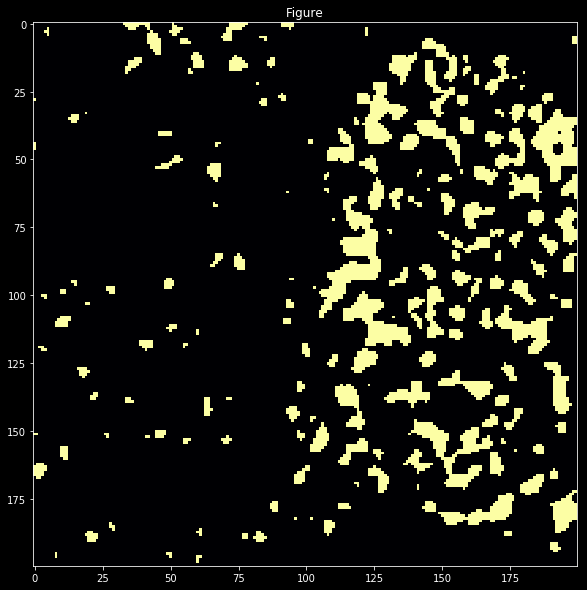

In [9]:
Display((np.sum(cstk,axis=2)>np.percentile(np.sum(cstk,axis=2).ravel(),95))[900:1100,650:850],rel_min=0,rel_max=100)

In [10]:
# Generate candidate vectors for multiple positions
from tqdm import tqdm
import random
dataset = 'A4_2020Jun28'
rel_peak_thresh = 95
vector_list = []
all_df = []
normalization_factors = 1000*np.ones(nbits)
for posname in random.sample(posnames,5):
    try:
        flag = fishdata.load_data('flag',dataset=dataset,posname=posname)
    except:
        continue
    if flag!='Passed':
        print(posname,'Failed')
        continue
    for zindex in tqdm([15,17,19,21]):
        cstk = load_codestack(fishdata,bitmap,dataset,posname,zindex)
        cstk = gaussian(cstk,(1,1,0))
        max_stk = np.sum(cstk,axis=2)
        xy = np.where(max_stk>np.percentile(max_stk.ravel(),rel_peak_thresh))
        v = cstk[xy[0],xy[1],:]
        break
    break
    
#         v = cstk[xy[0],xy[1],:]
#         dimg,cimg = classify(cstk,normalization_factors,codeword_vectors,rel_peak_thresh=rel_peak_thresh)
#         df = parse_classification_image(cimg, cstk, codeword_vectors, genes, zindex, dimg)
#         df['posname'] = posname
#         all_df.append(df)
# merged_df = pd.concat(all_df,ignore_index=True)
#         vector_list.append(vectors)
# vectors = np.concatenate(vector_list)

  0%|          | 0/4 [00:06<?, ?it/s]


In [51]:
dataset = 'A4_2020Jun28'
normalization_factors = 1000*np.ones(cstk.shape[2])
cstk = load_codestack(fishdata,bitmap,dataset,pos,z)
dimg,cimg = classify_pixels(cstk,normalization_factors,codeword_vectors,rel_peak_thresh=99)
df = parse_classification_image(cimg, cstk, codeword_vectors, genes, z, dimg)
df['posname'] = pos
df

,gene,ssum,centroid,ave,npixels,cword_idx,cword_dist,posname
0,NOVA1,4098.0,"(0.0, 196.0)",1024.500000,1,89,0.568115,Pos1
1,high_decoy732,8318.0,"(0.0, 263.0)",1188.285714,1,937,0.719865,Pos1
2,TBC1D9B,4602.0,"(0.0, 264.0)",1150.500000,1,148,0.693545,Pos1
3,high_decoy25689,19880.0,"(0.0, 666.5)",1420.000000,2,25894,0.549155,Pos1
4,high_decoy21024,11774.0,"(0.0, 668.0)",1682.000000,1,21229,0.659769,Pos1
5,CPEB1,6316.0,"(0.0, 669.0)",1579.000000,1,25,0.671183,Pos1
6,OXR1,9673.0,"(0.0, 1009.5)",1209.125000,2,92,0.626874,Pos1
7,MNT,4286.0,"(0.0, 1011.0)",1071.500000,1,84,0.651685,Pos1
8,egfp,3979.0,"(0.0, 1012.0)",994.750000,1,169,0.738511,Pos1
9,PTPN12,4137.0,"(0.0, 1013.0)",1034.250000,1,111,0.616304,Pos1


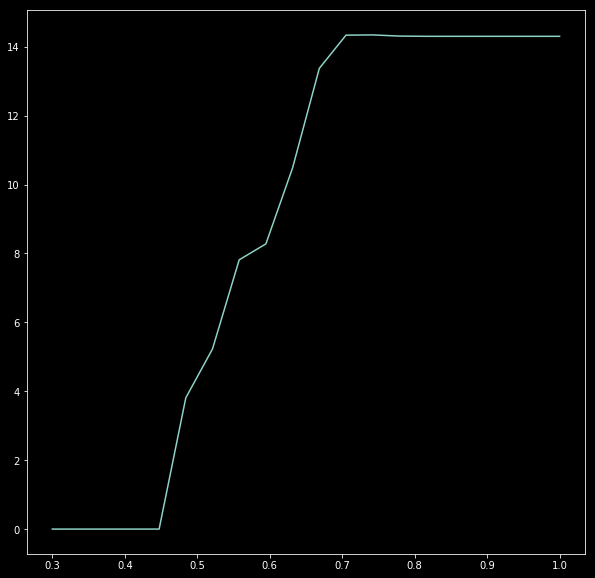

In [39]:
cword_dist_thresh = np.linspace(0.3,1,20)
blanks = [i for i in df['gene'].unique() if 'blank' in i]
decoys = [i for i in df['gene'].unique() if 'decoy' in i]
trues = [i for i in df['gene'].unique() if not ('decoy' in i)|('blank' in i)]
fpr_out = []
for cword_dist in cword_dist_thresh:
    temp = df[df['cword_dist']<cword_dist]
#     decoy_df = temp[np.isin(temp['gene'],decoys)]
    blank_df = temp[np.isin(temp['gene'],blanks)]
    true_df = temp[np.isin(temp['gene'],trues)]
    blank_count = len(blank_df)
#     decoy_count = len(decoy_df)
    true_count = len(true_df)
    fpr = round(100*(blank_count/len(blanks))/((true_count+blank_count)/(len(blanks)+len(trues))),3)
#     print(fpr,'% ',true_count)
    fpr_out.append(fpr)
plt.figure(figsize=[10,10])
plt.plot(cword_dist_thresh,fpr_out)
plt.show()

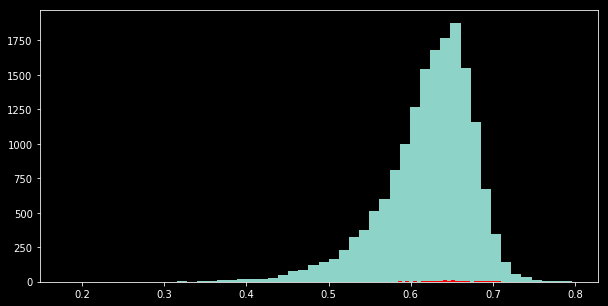

In [40]:
plt.figure(figsize=[10,5])
plt.hist(true_df.cword_dist,bins=50)
plt.hist(blank_df.cword_dist,bins=50,color='r')
plt.show()

In [7]:
blank_indexes = [i for i,gene in enumerate(genes) if 'blank' in gene]
true_indexes = [i for i,gene in enumerate(genes) if not ('blank' in gene)|('decoy' in gene)]

In [9]:
def calculate_fpr(cimg,genes,codeword_vectors):
    blank_indexes = [i for i,gene in enumerate(genes) if 'blank' in gene]
    true_indexes = [i for i,gene in enumerate(genes) if not ('blank' in gene)|('decoy' in gene)]
    
    b_xy = np.where(np.isin(cimg,blank_indexes))
    # blank_vectors = cstk[b_xy[0],b_xy[1],:]
    blank_cimg = cimg[b_xy[0],b_xy[1]].astype(int)
    blank_codewords = codeword_vectors[blank_cimg,:]
    blank_counts = np.sum(blank_codewords,axis=0)

    t_xy = np.where(np.isin(cimg,true_indexes))
    # true_vectors = cstk[t_xy[0],t_xy[1],:]
    true_cimg = cimg[t_xy[0],t_xy[1]].astype(int)
    true_codewords = codeword_vectors[true_cimg,:]
    true_counts = np.sum(true_codewords,axis=0)

    correction = (len(true_indexes)+len(blank_indexes))/len(blank_indexes)
    bit_fpr = correction*(blank_counts)/(true_counts+blank_counts)
    total_fpr = correction*blank_cimg.shape[0]/true_cimg.shape[0]
    total_counts = true_cimg.shape[0]
    return bit_fpr,total_fpr,total_counts
# calculate_fpr(cimg,genes,codeword_vectors)

 10%|█         | 1/10 [01:30<13:33, 90.40s/it]

iteration 0
bit fpr ['18%', '147%', '87%', '211%', '80%', '50%', '46%', '59%', '58%', '78%', '134%', '27%', '147%', '77%', '7%', '81%', '57%', '63%']
total fpr 0.8120332181473637
total counts 35884
nf [1012, 1141, 1081, 1206, 1075, 1044, 1041, 1053, 1053, 1073, 1129, 1021, 1142, 1072, 1001, 1076, 1051, 1058]


 20%|██        | 2/10 [03:01<12:04, 90.55s/it]

iteration 1
bit fpr ['19%', '138%', '79%', '200%', '73%', '46%', '42%', '57%', '58%', '71%', '128%', '24%', '136%', '72%', '7%', '74%', '50%', '58%']
total fpr 0.7391917293233082
total counts 36176
nf [1026, 1294, 1161, 1441, 1148, 1087, 1079, 1108, 1109, 1143, 1267, 1041, 1291, 1144, 1003, 1150, 1099, 1114]


 30%|███       | 3/10 [04:32<10:34, 90.60s/it]

iteration 2
bit fpr ['20%', '130%', '74%', '192%', '67%', '42%', '39%', '57%', '57%', '66%', '123%', '22%', '129%', '68%', '8%', '71%', '47%', '52%']
total fpr 0.6867076450249712
total counts 36442
nf [1042, 1456, 1242, 1711, 1219, 1127, 1116, 1166, 1166, 1212, 1418, 1058, 1452, 1215, 1006, 1226, 1145, 1166]


 40%|████      | 4/10 [06:02<09:03, 90.58s/it]

iteration 3
bit fpr ['21%', '122%', '67%', '178%', '61%', '37%', '36%', '57%', '57%', '61%', '119%', '20%', '121%', '65%', '9%', '66%', '43%', '46%']
total fpr 0.6308232986432736
total counts 36706
nf [1058, 1626, 1319, 2007, 1287, 1164, 1150, 1226, 1227, 1280, 1579, 1074, 1621, 1288, 1010, 1300, 1189, 1214]


 50%|█████     | 5/10 [07:33<07:33, 90.61s/it]

iteration 4
bit fpr ['22%', '117%', '62%', '172%', '57%', '34%', '32%', '55%', '56%', '56%', '115%', '18%', '114%', '61%', '9%', '62%', '41%', '43%']
total fpr 0.5854483467720115
total counts 36958
nf [1076, 1808, 1394, 2342, 1354, 1198, 1181, 1288, 1289, 1345, 1754, 1088, 1797, 1360, 1014, 1375, 1232, 1260]


 60%|██████    | 6/10 [09:03<06:02, 90.61s/it]

iteration 5
bit fpr ['22%', '110%', '58%', '161%', '52%', '31%', '31%', '53%', '54%', '51%', '111%', '16%', '110%', '59%', '9%', '58%', '37%', '39%']
total fpr 0.5413566151779718
total counts 37225
nf [1094, 1998, 1467, 2708, 1418, 1229, 1212, 1350, 1353, 1406, 1940, 1101, 1986, 1434, 1017, 1447, 1271, 1303]


 70%|███████   | 7/10 [10:34<04:31, 90.63s/it]

iteration 6
bit fpr ['23%', '108%', '54%', '161%', '48%', '29%', '28%', '52%', '54%', '47%', '106%', '15%', '106%', '57%', '9%', '55%', '36%', '36%']
total fpr 0.5102411408123482
total counts 37447
nf [1114, 2204, 1539, 3132, 1478, 1259, 1240, 1414, 1419, 1465, 2135, 1112, 2187, 1509, 1021, 1519, 1310, 1344]


 80%|████████  | 8/10 [12:05<03:01, 90.62s/it]

iteration 7
bit fpr ['24%', '106%', '50%', '152%', '44%', '27%', '26%', '51%', '54%', '43%', '103%', '14%', '102%', '55%', '9%', '51%', '35%', '35%']
total fpr 0.47991385956982957
total counts 37613
nf [1135, 2427, 1608, 3593, 1536, 1287, 1266, 1479, 1489, 1520, 2344, 1121, 2400, 1584, 1026, 1589, 1350, 1384]


 90%|█████████ | 9/10 [13:35<01:30, 90.63s/it]

iteration 8
bit fpr ['22%', '102%', '48%', '147%', '39%', '26%', '24%', '47%', '50%', '38%', '95%', '12%', '102%', '52%', '9%', '48%', '35%', '33%']
total fpr 0.4443504467826363
total counts 37826
nf [1154, 2662, 1677, 4104, 1588, 1314, 1291, 1540, 1555, 1570, 2555, 1130, 2632, 1660, 1030, 1658, 1391, 1423]


100%|██████████| 10/10 [15:06<00:00, 90.64s/it]

iteration 9
bit fpr ['22%', '99%', '45%', '142%', '35%', '24%', '22%', '45%', '48%', '35%', '90%', '11%', '99%', '50%', '9%', '46%', '33%', '31%']
total fpr 0.4151380982500527
total counts 37944
nf [1174, 2913, 1743, 4665, 1636, 1339, 1313, 1602, 1622, 1617, 2773, 1137, 2879, 1734, 1035, 1726, 1430, 1460]
907.9251005649567


In [21]:
import time
start = time.time()
dataset = 'A4_2020Jun28'
pos = 'Pos1'
z = 17
scaling_factor = 0.3
ideal = 0.05
normalization_factors = 1000*np.ones(cstk.shape[2])
iterations = 10
nf_out = np.zeros((iterations+1,normalization_factors.shape[0]))
bit_fpr_out = np.zeros((iterations,normalization_factors.shape[0]))
total_fpr_out = np.zeros(iterations)
total_counts_out = np.zeros(iterations)
cstk = load_codestack(fishdata,bitmap,dataset,pos,z)
for i in tqdm(range(iterations)):
    nf_out[i,:] = normalization_factors
    dimg,cimg = classify_pixels(cstk,normalization_factors,codeword_vectors,rel_peak_thresh=99)
    bit_fpr,total_fpr,total_counts = calculate_fpr(cimg,genes,codeword_vectors)
    normalization_factors = normalization_factors+normalization_factors*(scaling_factor*(bit_fpr-ideal))
    bit_fpr_out[i,:] = bit_fpr
    total_fpr_out[i] = total_fpr
    total_counts_out[i] = total_counts
    print('iteration',i)
    print('bit fpr',[str(round(100*i))+'%' for i in bit_fpr])
    print('total fpr',total_fpr)
    print('total counts',total_counts)
    print('nf',[int(i) for i in normalization_factors])
# df = parse_classification_image(cimg, cstk, codeword_vectors, genes, z, dimg)

print(time.time()-start)

 10%|█         | 1/10 [01:31<13:39, 91.05s/it]

iteration 0
bit fpr ['18%', '147%', '87%', '211%', '80%', '50%', '46%', '59%', '58%', '78%', '134%', '27%', '147%', '77%', '7%', '81%', '57%', '63%']
total fpr 0.8120332181473637
total counts 35884
nf [1038, 1425, 1244, 1618, 1226, 1134, 1123, 1160, 1160, 1219, 1388, 1064, 1426, 1216, 1004, 1228, 1155, 1174]


 20%|██        | 2/10 [03:02<12:08, 91.10s/it]

iteration 1
bit fpr ['22%', '124%', '68%', '180%', '63%', '38%', '35%', '58%', '59%', '63%', '121%', '21%', '122%', '65%', '9%', '68%', '44%', '48%']
total fpr 0.6480666757753791
total counts 36595
nf [1090, 1935, 1480, 2468, 1440, 1248, 1226, 1345, 1347, 1429, 1871, 1116, 1926, 1437, 1015, 1461, 1290, 1325]


 30%|███       | 3/10 [04:33<10:37, 91.07s/it]

iteration 2
bit fpr ['23%', '109%', '56%', '161%', '50%', '30%', '28%', '53%', '55%', '49%', '108%', '16%', '106%', '58%', '9%', '56%', '37%', '38%']
total fpr 0.526595744680851
total counts 37224
nf [1148, 2540, 1704, 3625, 1637, 1343, 1312, 1538, 1549, 1618, 2449, 1154, 2512, 1665, 1027, 1686, 1414, 1455]


 40%|████      | 4/10 [06:04<09:06, 91.01s/it]

iteration 3
bit fpr ['22%', '102%', '48%', '149%', '38%', '26%', '23%', '47%', '50%', '37%', '93%', '13%', '100%', '52%', '9%', '48%', '35%', '33%']
total fpr 0.43929899097185343
total counts 37660
nf [1207, 3279, 1922, 5192, 1800, 1426, 1384, 1730, 1760, 1775, 3093, 1181, 3228, 1898, 1041, 1902, 1539, 1576]


 50%|█████     | 5/10 [07:35<07:35, 91.03s/it]

iteration 4
bit fpr ['22%', '95%', '41%', '126%', '31%', '21%', '19%', '45%', '47%', '31%', '89%', '10%', '97%', '48%', '10%', '43%', '33%', '28%']
total fpr 0.3790797854065911
total counts 37839
nf [1268, 4168, 2129, 7073, 1941, 1494, 1443, 1935, 1980, 1914, 3874, 1197, 4117, 2142, 1056, 2120, 1667, 1686]


 60%|██████    | 6/10 [09:06<06:04, 91.02s/it]

iteration 5
bit fpr ['21%', '92%', '36%', '102%', '25%', '19%', '16%', '41%', '43%', '24%', '82%', '7%', '98%', '45%', '9%', '39%', '29%', '25%']
total fpr 0.3286314287978445
total counts 37857
nf [1329, 5253, 2323, 9136, 2056, 1555, 1493, 2147, 2208, 2025, 4774, 1204, 5270, 2396, 1069, 2338, 1787, 1789]


 70%|███████   | 7/10 [10:37<04:33, 91.03s/it]

iteration 6
bit fpr ['19%', '86%', '31%', '78%', '20%', '16%', '13%', '38%', '38%', '20%', '75%', '5%', '97%', '40%', '9%', '35%', '28%', '22%']
total fpr 0.2809435951502372
total counts 37940
nf [1386, 6530, 2504, 11134, 2146, 1606, 1531, 2358, 2428, 2114, 5770, 1204, 6727, 2648, 1082, 2551, 1908, 1881]


 80%|████████  | 8/10 [12:08<03:02, 91.02s/it]

iteration 7
bit fpr ['17%', '82%', '29%', '57%', '17%', '14%', '12%', '34%', '34%', '16%', '69%', '4%', '98%', '37%', '8%', '32%', '25%', '19%']
total fpr 0.24575177174170773
total counts 37957
nf [1437, 8038, 2688, 12882, 2222, 1651, 1565, 2564, 2640, 2184, 6884, 1199, 8603, 2904, 1092, 2754, 2021, 1961]


 90%|█████████ | 9/10 [13:39<01:31, 91.03s/it]

iteration 8
bit fpr ['16%', '76%', '26%', '40%', '14%', '13%', '10%', '33%', '31%', '13%', '64%', '2%', '91%', '33%', '7%', '30%', '23%', '17%']
total fpr 0.21346235194585447
total counts 37824
nf [1485, 9751, 2856, 14215, 2279, 1690, 1588, 2776, 2847, 2236, 8107, 1190, 10814, 3150, 1100, 2957, 2128, 2032]


100%|██████████| 10/10 [15:10<00:00, 91.03s/it]

iteration 9
bit fpr ['14%', '73%', '23%', '32%', '12%', '12%', '8%', '31%', '29%', '11%', '63%', '2%', '82%', '30%', '7%', '28%', '21%', '16%']
total fpr 0.18949408079842864
total counts 37674
nf [1527, 11738, 3010, 15345, 2326, 1724, 1603, 2994, 3050, 2274, 9512, 1179, 13316, 3383, 1107, 3161, 2233, 2097]
912.1319630146027


In [24]:
for i in tqdm([10,11,12,13,14,15,16,17,18,19]):
    dimg,cimg = classify_pixels(cstk,normalization_factors,codeword_vectors,rel_peak_thresh=99)
    bit_fpr,total_fpr,total_counts = calculate_fpr(cimg,genes,codeword_vectors)
    normalization_factors = normalization_factors+normalization_factors*(scaling_factor*(bit_fpr-ideal))
    print('iteration',i)
    print('bit fpr',[str(round(100*i))+'%' for i in bit_fpr])
    print('total fpr',total_fpr)
    print('total counts',total_counts)
    print('nf',[int(i) for i in normalization_factors])

 10%|█         | 1/10 [01:31<13:40, 91.12s/it]

iteration 10
bit fpr ['13%', '69%', '21%', '21%', '9%', '11%', '7%', '28%', '25%', '9%', '59%', '1%', '77%', '27%', '6%', '26%', '19%', '14%']
total fpr 0.16512465004666044
total counts 37505
nf [1562, 13980, 3156, 16091, 2356, 1753, 1615, 3202, 3231, 2301, 11042, 1165, 16198, 3607, 1110, 3362, 2326, 2155]


 20%|██        | 2/10 [03:02<12:08, 91.12s/it]

iteration 11
bit fpr ['12%', '65%', '19%', '17%', '8%', '9%', '7%', '26%', '24%', '7%', '53%', '1%', '74%', '26%', '5%', '24%', '16%', '13%']
total fpr 0.14741902562174355
total counts 37234
nf [1595, 16496, 3290, 16657, 2376, 1776, 1622, 3407, 3411, 2316, 12620, 1151, 19531, 3838, 1109, 3549, 2406, 2203]


 30%|███       | 3/10 [04:33<10:37, 91.09s/it]

iteration 12
bit fpr ['12%', '63%', '17%', '13%', '7%', '9%', '5%', '25%', '22%', '7%', '48%', '1%', '66%', '24%', '4%', '23%', '16%', '12%']
total fpr 0.13241181562432375
total counts 36968
nf [1627, 19348, 3405, 17060, 2387, 1795, 1624, 3610, 3581, 2327, 14238, 1136, 23121, 4059, 1106, 3738, 2483, 2248]


 40%|████      | 4/10 [06:04<09:06, 91.08s/it]

iteration 13
bit fpr ['10%', '59%', '15%', '11%', '6%', '8%', '5%', '23%', '20%', '6%', '49%', '1%', '66%', '23%', '3%', '21%', '14%', '11%']
total fpr 0.12104704055784055
total counts 36713
nf [1653, 22511, 3509, 17376, 2395, 1810, 1624, 3809, 3746, 2334, 16119, 1120, 27363, 4275, 1101, 3922, 2549, 2286]


 50%|█████     | 5/10 [07:35<07:35, 91.09s/it]

iteration 14
bit fpr ['9%', '53%', '14%', '7%', '5%', '7%', '4%', '21%', '18%', '5%', '44%', '0%', '63%', '21%', '3%', '19%', '13%', '9%']
total fpr 0.10610544776937411
total counts 36492
nf [1673, 25749, 3607, 17473, 2398, 1820, 1621, 3997, 3892, 2335, 18020, 1105, 32088, 4476, 1094, 4085, 2611, 2316]


 60%|██████    | 6/10 [09:06<06:04, 91.06s/it]

iteration 15
bit fpr ['8%', '50%', '13%', '5%', '5%', '6%', '4%', '20%', '16%', '5%', '40%', '0%', '60%', '19%', '3%', '18%', '13%', '8%']
total fpr 0.09629138707094137
total counts 36213
nf [1689, 29246, 3695, 17475, 2398, 1826, 1616, 4178, 4022, 2334, 19906, 1089, 37370, 4667, 1087, 4239, 2676, 2340]


 70%|███████   | 7/10 [10:37<04:33, 91.07s/it]

iteration 16
bit fpr ['8%', '50%', '13%', '4%', '5%', '6%', '4%', '20%', '16%', '4%', '37%', '0%', '59%', '19%', '3%', '17%', '14%', '8%']
total fpr 0.09271210013908206
total counts 35950
nf [1705, 33161, 3784, 17430, 2395, 1830, 1609, 4367, 4153, 2330, 21820, 1073, 43411, 4867, 1081, 4393, 2744, 2363]


 80%|████████  | 8/10 [12:08<03:02, 91.05s/it]

iteration 17
bit fpr ['7%', '47%', '13%', '4%', '4%', '5%', '4%', '19%', '15%', '4%', '35%', '0%', '58%', '19%', '3%', '16%', '13%', '7%']
total fpr 0.08616830796777082
total counts 35744
nf [1717, 37328, 3871, 17383, 2391, 1832, 1602, 4552, 4276, 2324, 23803, 1057, 50268, 5067, 1073, 4534, 2811, 2380]


 90%|█████████ | 9/10 [13:39<01:31, 91.01s/it]

iteration 18
bit fpr ['7%', '47%', '13%', '5%', '4%', '5%', '3%', '19%', '14%', '4%', '33%', '0%', '57%', '19%', '2%', '15%', '13%', '7%']
total fpr 0.08342496264343512
total counts 35469
nf [1728, 42060, 3961, 17378, 2386, 1832, 1595, 4740, 4397, 2316, 25790, 1042, 58143, 5276, 1065, 4675, 2881, 2395]


100%|██████████| 10/10 [15:10<00:00, 91.05s/it]

iteration 19
bit fpr ['6%', '48%', '13%', '3%', '4%', '5%', '3%', '17%', '12%', '4%', '29%', '0%', '59%', '18%', '2%', '14%', '13%', '7%']
total fpr 0.07758767208656733
total counts 35302
nf [1733, 47476, 4054, 17286, 2378, 1831, 1588, 4906, 4495, 2307, 27672, 1026, 67545, 5476, 1056, 4808, 2947, 2409]


16219.0


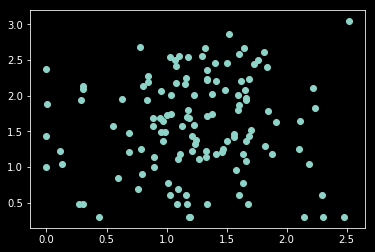

(0.04674049013849443, 0.6032615270315683)
SpearmanrResult(correlation=0.06439142881865026, pvalue=0.4737861419613014)


In [32]:
fpkm_path = '/bigstore/binfo/zebra_finch/RegionXExpression/Appended_FPKM.csv'
fpkm = pd.read_csv(fpkm_path,index_col=0)
df = parse_classification_image(cimg, cstk, codeword_vectors, genes, z, dimg)
df['posname'] = pos
true_df = df[(np.isin(df['cword_idx'],true_indexes))]
temp = true_df[(true_df.cword_dist<0.7)]#[true_df['npixels']>1]#df[(df.npixels>1)&(df.ave>10**2.9)&(df.cword_dist<0.52)]
print(len(temp)/len(df.posname.unique()))
shared_genes = set(fpkm.gene_short_name).intersection(temp.gene.unique())
shared_fpkm = fpkm[fpkm.gene_short_name.isin(shared_genes)].drop_duplicates('gene_short_name').sort_values('gene_short_name')
fish = pd.DataFrame(Counter(temp.gene).items())
shared_fish = fish[fish[0].isin(shared_genes)].sort_values(0)
plt.scatter(np.log10(shared_fpkm.FPKM+1),np.log10(shared_fish[1]+1))
plt.show()
from scipy.stats import pearsonr
print(pearsonr(np.log10(shared_fpkm.FPKM+1),np.log10(shared_fish[1]+1)))
print(spearmanr(shared_fpkm.FPKM,shared_fish[1]))

In [33]:
normalization_factors

array([ 1733.99909277, 47476.32608671,  4054.33574593, 17286.90545698,
        2378.16198414,  1831.83765817,  1588.04756175,  4906.35072611,
        4495.95495225,  2307.50783288, 27672.59139746,  1026.90682692,
       67545.79933558,  5476.97372168,  1056.41114321,  4808.74584869,
        2947.92859095,  2409.89374713])

In [36]:
decoy_indexes = [i for i,gene in enumerate(genes) if ('decoy' in gene)]
df[(np.isin(df['cword_idx'],decoy_indexes)==False)]

,gene,ssum,centroid,ave,npixels,cword_idx,cword_dist,posname
1,STIM2,4829.0,"(0.0, 263.0)",1207.250000,1,144,0.651362,Pos1
3,NF1,11727.0,"(0.0, 666.5)",1465.875000,2,88,0.622847,Pos1
4,SLIT1,7680.0,"(0.0, 668.0)",1920.000000,1,132,0.679589,Pos1
5,UPF3B,5649.0,"(0.0, 669.0)",1412.250000,1,161,0.601838,Pos1
6,RUFY3,2942.0,"(0.0, 1009.0)",735.500000,1,120,0.640083,Pos1
8,MNT,4286.0,"(0.0, 1011.0)",1071.500000,1,84,0.748677,Pos1
9,GRM5,3673.0,"(0.0, 1012.0)",918.250000,1,57,0.718172,Pos1
10,FOXP4,3212.0,"(0.0, 1013.0)",803.000000,1,53,0.678946,Pos1
13,NF1,3149.0,"(0.0, 1080.0)",787.250000,1,88,0.654218,Pos1
14,SLIT1,4880.0,"(0.0, 1512.0)",1220.000000,1,132,0.542837,Pos1


In [42]:
# Generate candidate vectors for multiple positions
from tqdm import tqdm
import random
dataset = 'A4_2020Jun28'
rel_peak_thresh = 99
vector_list = []
all_df = []
all_df.append(df[(np.isin(df['cword_idx'],decoy_indexes)==False)])
# normalization_factors = 1000*np.ones(nbits)
for posname in random.sample(posnames,5):
    try:
        flag = fishdata.load_data('flag',dataset=dataset,posname=posname)
    except:
        continue
    if flag!='Passed':
        print(posname,'Failed')
        continue
    for zindex in tqdm([15,17,19,21],desc=posname):
        cstk = load_codestack(fishdata,bitmap,dataset,posname,zindex)
        cstk = gaussian(cstk,(1,1,0))
        dimg,cimg = classify_pixels(cstk,normalization_factors,codeword_vectors,rel_peak_thresh=99)
        df = parse_classification_image(cimg, cstk, codeword_vectors, genes, zindex, dimg)
        df['posname'] = posname
        df = df[(np.isin(df['cword_idx'],decoy_indexes)==False)]
        all_df.append(df)
merged_df = pd.concat(all_df,ignore_index=True)

Pos81: 100%|██████████| 4/4 [07:36<00:00, 114.12s/it]


7405.6


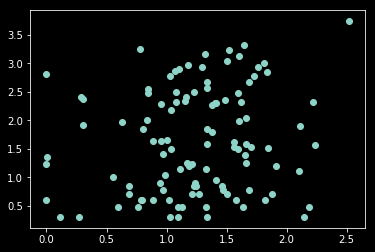

(0.15714139987405976, 0.10271207278836163)
SpearmanrResult(correlation=0.154124661613048, pvalue=0.10956884225335804)


In [72]:
fpkm_path = '/bigstore/binfo/zebra_finch/RegionXExpression/Appended_FPKM.csv'
fpkm = pd.read_csv(fpkm_path,index_col=0)
df = merged_df#parse_classification_image(cimg, cstk, codeword_vectors, genes, z, dimg)
# df['posname'] = pos
true_df = df[(np.isin(df['cword_idx'],true_indexes))]
temp = true_df[(true_df.cword_dist<0.6)&(true_df['npixels']>2)]#df[(df.npixels>1)&(df.ave>10**2.9)&(df.cword_dist<0.52)]
print(len(temp)/5)#len(df.posname.unique()))
shared_genes = set(fpkm.gene_short_name).intersection(temp.gene.unique())
shared_fpkm = fpkm[fpkm.gene_short_name.isin(shared_genes)].drop_duplicates('gene_short_name').sort_values('gene_short_name')
fish = pd.DataFrame(Counter(temp.gene).items())
shared_fish = fish[fish[0].isin(shared_genes)].sort_values(0)
plt.scatter(np.log10(shared_fpkm.FPKM+1),np.log10(shared_fish[1]+1))
plt.show()
from scipy.stats import pearsonr
print(pearsonr(np.log10(shared_fpkm.FPKM+1),np.log10(shared_fish[1]+1)))
print(spearmanr(shared_fpkm.FPKM,shared_fish[1]))

In [58]:
merged_df.head()

,gene,ssum,centroid,ave,npixels,cword_idx,cword_dist,posname
0,STIM2,4829.0,"(0.0, 263.0)",1207.250,1,144,0.651362,Pos1
1,NF1,11727.0,"(0.0, 666.5)",1465.875,2,88,0.622847,Pos1
2,SLIT1,7680.0,"(0.0, 668.0)",1920.000,1,132,0.679589,Pos1
3,UPF3B,5649.0,"(0.0, 669.0)",1412.250,1,161,0.601838,Pos1
4,RUFY3,2942.0,"(0.0, 1009.0)",735.500,1,120,0.640083,Pos1


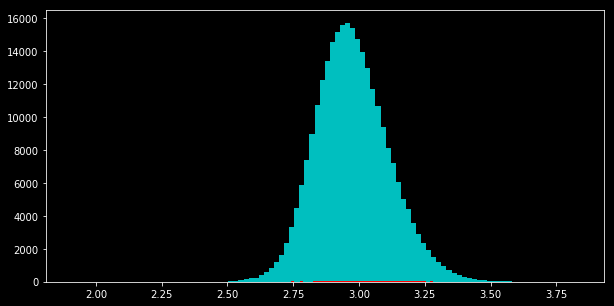

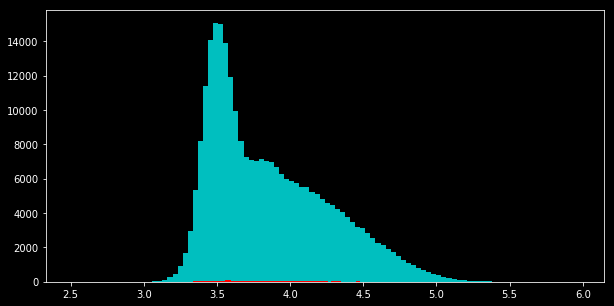

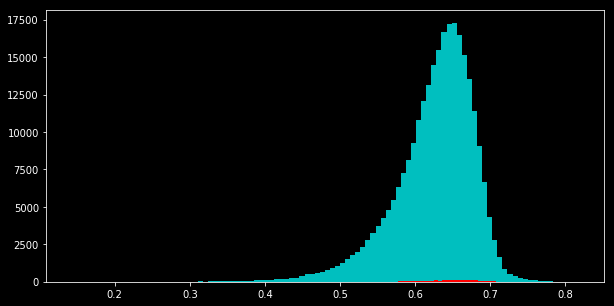

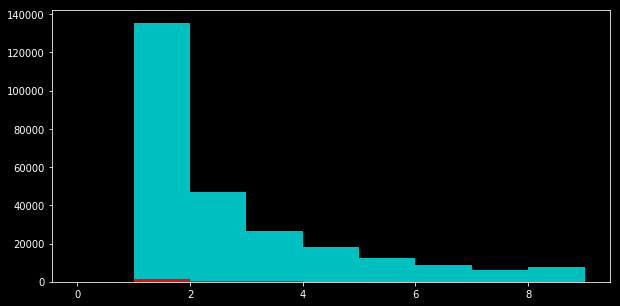

In [67]:
blank_df = merged_df[np.isin(merged_df['cword_idx'],blank_indexes)]
true_df = merged_df[np.isin(merged_df['cword_idx'],true_indexes)]
plt.figure(figsize=[10,5])
plt.hist(np.log10(true_df['ave']+1),bins=100,color='c')
plt.hist(np.log10(blank_df['ave']+1),bins=100,color='r')
plt.show()
plt.figure(figsize=[10,5])
plt.hist(np.log10(true_df['ssum']+1),bins=100,color='c')
plt.hist(np.log10(blank_df['ssum']+1),bins=100,color='r')
plt.show()
plt.figure(figsize=[10,5])
plt.hist(true_df['cword_dist'],bins=100,color='c')
plt.hist(blank_df['cword_dist'],bins=100,color='r')
plt.show()
plt.figure(figsize=[10,5])
plt.hist(true_df['npixels'],bins=range(10),color='c')
plt.hist(blank_df['npixels'],bins=range(10),color='r')
plt.show()

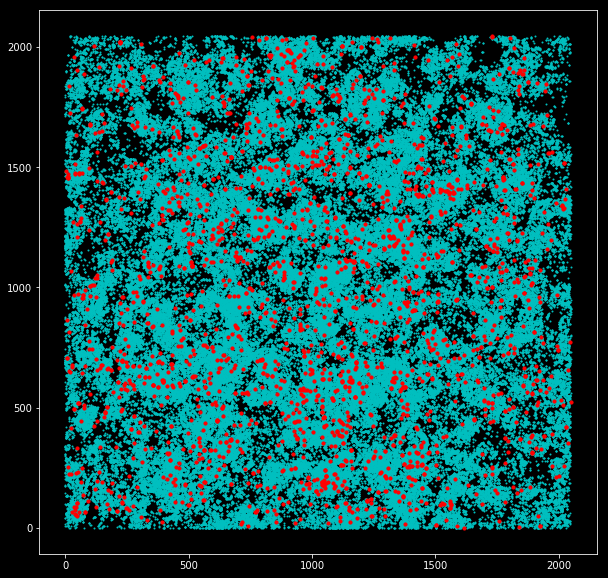

In [53]:
plt.figure(figsize=[10,10])
xy = np.stack(true_df['centroid'])
plt.scatter(xy[:,0],xy[:,1],c='c',s=1)
xy = np.stack(blank_df['centroid'])
plt.scatter(xy[:,0],xy[:,1],c='r',s=10)
plt.show()

In [68]:
correction = (len(blank_indexes)+len(true_indexes))/len(blank_indexes)
temp = merged_df[merged_df['npixels']>1]
blank_df = temp[np.isin(temp['cword_idx'],blank_indexes)]
true_df = temp[np.isin(temp['cword_idx'],true_indexes)]
correction*(len(blank_df)/(len(blank_df)+len(true_df)))

0.0741235586279009